In [1]:
import tensorflow as tf

# List all physical devices of type GPU
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        gpu_details = tf.config.experimental.get_device_details(gpu)
        gpu_name = gpu_details.get('device_name', 'Unknown GPU')
        print(f"Found a GPU with ID: {gpu}, Name: {gpu_name}")
else:
    print("Failed to detect a GPU.")


Found a GPU with ID: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, Add,
    GlobalAveragePooling2D, Dense, Dropout, Layer
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)

# Ensure Pillow is installed
!pip install Pillow

import PIL


In [3]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Enable mixed precision globally
mixed_precision.set_global_policy('mixed_float16')

def build_baseline_cnn(input_shape=(224, 224, 3), num_classes=2):
    base_model = EfficientNetB0(include_top=False,
                               input_shape=input_shape,
                               weights='imagenet')
    base_model.trainable = False  # freeze backbone

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output dtype float32 to avoid mixed precision issues
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs, name="EffNetB0_Baseline")
    return model

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4050 Laptop GPU, compute capability 8.9


In [1]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size   = 32
max_samples  = 10000
target_size  = (224, 224)
classes      = ['fake', 'real']

def create_dataframe_from_dir(base_dir, max_samples, classes):
    data = []
    for label in classes:
        class_dir = os.path.join(base_dir, label)
        files = [os.path.join(class_dir, f)
                 for f in os.listdir(class_dir)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(files)
        n_per_class = max_samples // len(classes)
        for f in files[:n_per_class]:
            data.append({'filename': f, 'class': label})
    return pd.DataFrame(data)

# Assemble dataframes
train_df = create_dataframe_from_dir(
    r"D:\Hybrid with 140k Real and Fake Faces\real_vs_fake\real-vs-fake\train",
    max_samples, classes)
val_df   = create_dataframe_from_dir(
    r"D:\Hybrid with 140k Real and Fake Faces\real_vs_fake\real-vs-fake\valid",
    max_samples, classes)
test_df  = create_dataframe_from_dir(
    r"D:\Hybrid with 140k Real and Fake Faces\real_vs_fake\real-vs-fake\test",
    max_samples, classes)

# Noise-injection function: adds Gaussian noise with σ=0.03
def add_gaussian_noise(img):
    noise = np.random.normal(loc=0.0, scale=0.03, size=img.shape)
    img_noisy = img + noise
    # clip back to valid range [0, 1] if your images are scaled that way
    return np.clip(img_noisy, 0.0, 1.0)

# Training-time augmentation per Table 2
data_aug_train = ImageDataGenerator(
    rotation_range=12,                   # up to ±12°
    zoom_range=[0.9, 1.1],               # slight zoom in/out up to 1.1×
    preprocessing_function=add_gaussian_noise
)

# No augmentation for val/test
data_aug_val = ImageDataGenerator()
data_aug_test = ImageDataGenerator()

# Generators
train_gen = data_aug_train.flow_from_dataframe(
    train_df, x_col='filename', y_col='class',
    target_size=target_size, batch_size=batch_size,
    class_mode='categorical', shuffle=True,
    interpolation='lanczos'
)

val_gen = data_aug_val.flow_from_dataframe(
    val_df, x_col='filename', y_col='class',
    target_size=target_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False,
    interpolation='lanczos'
)

test_gen = data_aug_test.flow_from_dataframe(
    test_df, x_col='filename', y_col='class',
    target_size=target_size, batch_size=batch_size,
    class_mode='categorical', shuffle=False,
    interpolation='lanczos'
)

# Steps per epoch / validation / test
steps_per_epoch   = max_samples // batch_size
validation_steps  = max_samples // batch_size
test_steps        = max_samples // batch_size


Found 100,200 validated image filenames belonging to 2 classes.
Found 20,200 validated image filenames belonging to 2 classes.
Found 20,100 validated image filenames belonging to 2 classes.


In [3]:
def infinite_generator(generator):
    while True:
        for batch in generator:
            yield batch

# Build and compile model
custom_cnn_model = build_baseline_cnn()

custom_cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
)

# === Initial Training ===
train_generator = infinite_generator(train_gen)  # Use train_gen from flow_from_dataframe
val_generator = infinite_generator(val_gen)      # Use val_gen from flow_from_dataframe

history = custom_cnn_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[reduce_lr, early_stopping]
)

# === Fine-tuning: Unfreeze base model ===
base_model = custom_cnn_model.layers[1]  # Assuming layer 1 is EfficientNetB0
base_model.trainable = True

custom_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Recreate generators again for fine-tuning (optional but good practice)
train_generator = infinite_generator(train_gen)
val_generator = infinite_generator(val_gen)

history_fine = custom_cnn_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[reduce_lr, early_stopping]
)

# === Evaluate on test data ===
test_generator = infinite_generator(test_gen)  # Use test_gen from flow_from_dataframe

test_loss, test_acc = custom_cnn_model.evaluate(
    test_generator,
    steps=test_steps
)

print(f"Test Accuracy: {test_acc:.4f}")

# === Save Final Model ===
custom_cnn_model.save('baselineA_model.h5')


Epoch 1/20
3125/3125 [==============================] - 393s 1s/step - loss: 0.5509 - accuracy: 0.7249 - val_loss: 0.4567 - val_accuracy: 0.7836 - lr: 0.0010
Epoch 2/20
3125/3125 [==============================] - 182s 584ms/step - loss: 0.4753 - accuracy: 0.7702 - val_loss: 0.4153 - val_accuracy: 0.8112 - lr: 0.0010
Epoch 3/20
3125/3125 [==============================] - 148s 477ms/step - loss: 0.4524 - accuracy: 0.7884 - val_loss: 0.4248 - val_accuracy: 0.8018 - lr: 0.0010
Epoch 4/20
3125/3125 [==============================] - 147s 472ms/step - loss: 0.4175 - accuracy: 0.8068 - val_loss: 0.4093 - val_accuracy: 0.8099 - lr: 0.0010
Epoch 5/20
3125/3125 [==============================] - 148s 475ms/step - loss: 0.4084 - accuracy: 0.8140 - val_loss: 0.3831 - val_accuracy: 0.8264 - lr: 0.0010
Epoch 6/20
3125/3125 [==============================] - 147s 471ms/step - loss: 0.3923 - accuracy: 0.8255 - val_loss: 0.3786 - val_accuracy: 0.8308 - lr: 0.0010
Epoch 7/20
3125/3125 [===============

In [6]:
# test evaluation
test_loss, test_accuracy = custom_cnn_model.evaluate(
    test_gen,
    steps=test_steps,
    verbose=1  
)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


3125/3125 [==============================] - 56s 179ms/step - loss: 0.1607 - accuracy: 0.9378
Test Accuracy: 0.9378
Test Loss: 0.1607


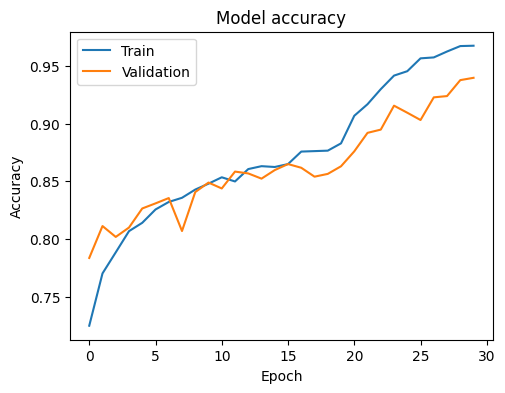

In [8]:
# Train vs validation validation accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

313/313 [==============================] - 56s 178ms/step


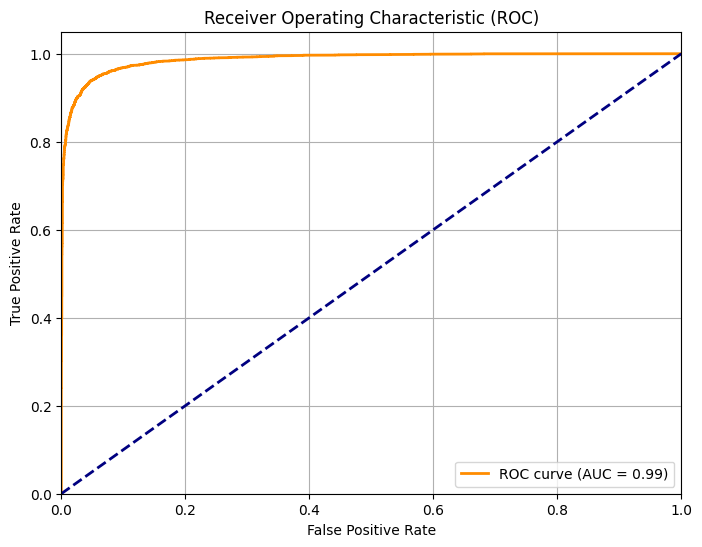

In [14]:
# Assuming you have a test generator 'test_gen' and your trained model 'custom_cnn_model'

# Step 1: Get the true labels from the generator
y_true = test_gen.classes  # true labels as integers

# Step 2: Get the predicted probabilities for the positive class (assuming binary classification)
# Use steps = ceil(num_samples / batch_size) to cover all test samples
import math
steps = math.ceil(len(y_true) / test_gen.batch_size)

# Predict probabilities
y_pred_prob_all = custom_cnn_model.predict(test_gen, steps=steps)
y_pred_prob = y_pred_prob_all[:len(y_true), 1] 

#  Compute ROC curve and AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


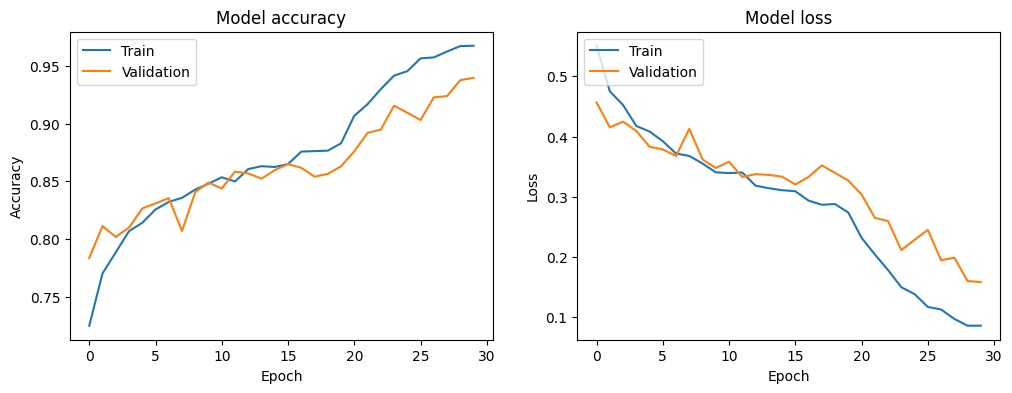

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [7]:
import numpy as np
import math

# Calculate steps to cover the entire test set
num_samples = len(test_gen.classes)
steps = math.ceil(num_samples / test_gen.batch_size)

# Evaluate the model on the test set
test_loss, test_acc = custom_cnn_model.evaluate(test_gen, steps=steps)
print('Test accuracy:', test_acc)

# Predict on the test set
predictions = custom_cnn_model.predict(test_gen, steps=steps)

# Convert predictions to class indices
y_pred = np.argmax(predictions, axis=1)

# Get true labels from the generator
y_true = test_gen.classes

# Trim predictions if they are longer than true labels (due to batch size padding)
y_pred = y_pred[:len(y_true)]



3125/3125 [==============================] - 57s 181ms/step - loss: 0.1606 - accuracy: 0.9379
Test accuracy: 0.9379
3125/3125 [==============================] - 56s 178ms/step


In [4]:
from sklearn.metrics import classification_report

target_names = list(test_gen.class_indices.keys())

# Print classification report
print(classification_report(y_true, y_pred, target_names=target_names))



              precision    recall  f1-score   support

        fake       0.96      0.91      0.94     10000
        real       0.92      0.96      0.94     10100

    accuracy                           0.94     20100
   macro avg       0.94      0.94      0.94     20100
weighted avg       0.94      0.94      0.94     20100



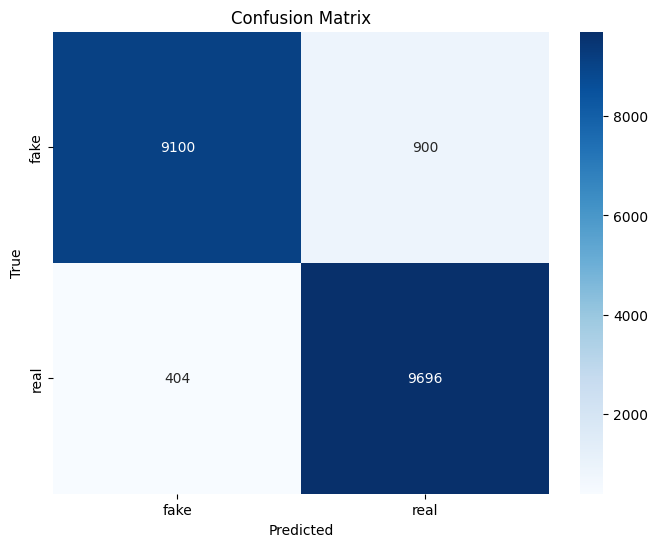

In [5]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Use the original test generator (not the infinite wrapper) for class indices
class_names = list(test_gen.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
